<a href="https://colab.research.google.com/github/MahdieRah/Protein_Feature_Extraction/blob/main/Mutation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload Two PDB Files in Google Colab
from google.colab import files
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Upload first PDB file
print("Please upload the first PDB file (wild-type)")
uploaded_1 = files.upload()
pdb_file_1 = list(uploaded_1.keys())[0]

# Upload second PDB file
print("Please upload the second PDB file (mutant)")
uploaded_2 = files.upload()
pdb_file_2 = list(uploaded_2.keys())[0]

Please upload the first PDB file (wild-type)


Saving 1crn.pdb to 1crn.pdb
Please upload the second PDB file (mutant)


Saving 1a6m.pdb to 1a6m.pdb


In [3]:
print(f"Uploaded files: {pdb_file_1}, {pdb_file_2}")

Uploaded files: 1crn.pdb, 1a6m.pdb


In [24]:
# Parse the PDB file into a DataFrame
def parse_pdb_to_df(file_path):
    columns = ['atom_name', 'residue_name', 'chain_id', 'residue_number', 'x', 'y', 'z']
    data = []
    with open(file_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_name = line[12:16].strip()
                residue_name = line[17:20].strip()
                chain_id = line[21].strip()
                residue_number = int(line[22:26].strip())
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                data.append([atom_name, residue_name, chain_id, residue_number, x, y, z])
    return pd.DataFrame(data, columns=columns)

In [25]:
# Parse wild-type (WT) and mutant (MT) PDB files into DataFrames
df_wt = parse_pdb_to_df(pdb_file_1)
df_mt = parse_pdb_to_df(pdb_file_2)

print("\nSample of Wild-Type DataFrame:")
print(df_wt.head())

print("\nSample of Mutant DataFrame:")
print(df_mt.head())



Sample of Wild-Type DataFrame:
  atom_name residue_name chain_id  residue_number       x       y      z
0         N          THR        A               1  17.047  14.099  3.625
1        CA          THR        A               1  16.967  12.784  4.338
2         C          THR        A               1  15.685  12.755  5.133
3         O          THR        A               1  15.268  13.825  5.594
4        CB          THR        A               1  18.170  12.703  5.337

Sample of Mutant DataFrame:
  atom_name residue_name chain_id  residue_number      x       y       z
0         N          VAL        A               1 -4.004  15.224  13.636
1        CA          VAL        A               1 -3.526  15.758  14.900
2         C          VAL        A               1 -2.662  14.733  15.628
3         O          VAL        A               1 -3.053  13.569  15.714
4        CB          VAL        A               1 -4.657  16.165  15.809


In [26]:
# Ensure Matching Atom Counts
min_atoms = min(len(df_wt), len(df_mt))
df_wt = df_wt.iloc[:min_atoms]
df_mt = df_mt.iloc[:min_atoms]

In [27]:
# Track Mutations
mutations = df_wt[df_wt['residue_name'] != df_mt['residue_name']]
mutations['mutant_residue'] = df_mt.loc[mutations.index, 'residue_name']

print("\nMutations Detected:")
print(mutations[['residue_name', 'mutant_residue', 'residue_number', 'chain_id']])


Mutations Detected:
    residue_name mutant_residue  residue_number chain_id
0            THR            VAL               1        A
1            THR            VAL               1        A
2            THR            VAL               1        A
3            THR            VAL               1        A
4            THR            VAL               1        A
..           ...            ...             ...      ...
322          ASN            GLU              46        A
323          ASN            GLU              46        A
324          ASN            GLU              46        A
325          ASN            GLU              46        A
326          ASN            GLU              46        A

[314 rows x 4 columns]


<ipython-input-27-d9730f8ae7b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutations['mutant_residue'] = df_mt.loc[mutations.index, 'residue_name']


In [29]:
# Detailed Mutation Report
mutation_report = mutations.merge(df_mt[['atom_name', 'residue_name', 'chain_id', 'residue_number']],
                                  on=['residue_number', 'chain_id'], suffixes=('_wt', '_mt'))
print("\nDetailed Mutation Report:")
# Access the renamed 'atom_name' column (likely 'atom_name_mt')
print(mutation_report[['atom_name_mt', 'residue_name_wt', 'residue_name_mt', 'residue_number', 'chain_id']])


Detailed Mutation Report:
     atom_name_mt residue_name_wt residue_name_mt  residue_number chain_id
0               N             THR             VAL               1        A
1              CA             THR             VAL               1        A
2               C             THR             VAL               1        A
3               O             THR             VAL               1        A
4              CB             THR             VAL               1        A
...           ...             ...             ...             ...      ...
2147           CB             ALA             GLU              38        A
2148           CG             ALA             GLU              38        A
2149           CD             ALA             GLU              38        A
2150          OE1             ALA             GLU              38        A
2151          OE2             ALA             GLU              38        A

[2152 rows x 5 columns]


In [30]:
# Extract Coordinates
coords_wt = df_wt[['x', 'y', 'z']].to_numpy()
coords_mt = df_mt[['x', 'y', 'z']].to_numpy()


In [31]:
# RMSD Calculation
def calculate_rmsd(P, Q):
    return np.sqrt(np.mean(np.sum((P - Q) ** 2, axis=1)))

rmsd_wt_vs_mt = calculate_rmsd(coords_wt, coords_mt)
print(f"\nGlobal RMSD (WT vs. MT): {rmsd_wt_vs_mt:.4f} Å")


Global RMSD (WT vs. MT): 21.0557 Å


In [32]:
# Per-Residue RMSD Calculation
def calculate_per_residue_rmsd(P, Q):
    return np.sqrt(np.sum((P - Q) ** 2, axis=1))

df_wt['rmsd_per_residue'] = calculate_per_residue_rmsd(coords_wt, coords_mt)


In [33]:
# Identify Structural Hotspots (High RMSD Regions)
rmsd_threshold = 2.0
hotspots = df_wt[df_wt['rmsd_per_residue'] > rmsd_threshold]
print("\nStructural Hotspots (RMSD > 2.0 Å):")
print(hotspots[['residue_name', 'residue_number', 'rmsd_per_residue']])


Structural Hotspots (RMSD > 2.0 Å):
    residue_name  residue_number  rmsd_per_residue
0            THR               1         23.337317
1            THR               1         23.245722
2            THR               1         21.228988
3            THR               1         20.931770
4            THR               1         25.351926
..           ...             ...               ...
322          ASN              46         27.169246
323          ASN              46         27.252413
324          ASN              46         27.026236
325          ASN              46         26.848903
326          ASN              46         22.110080

[327 rows x 3 columns]


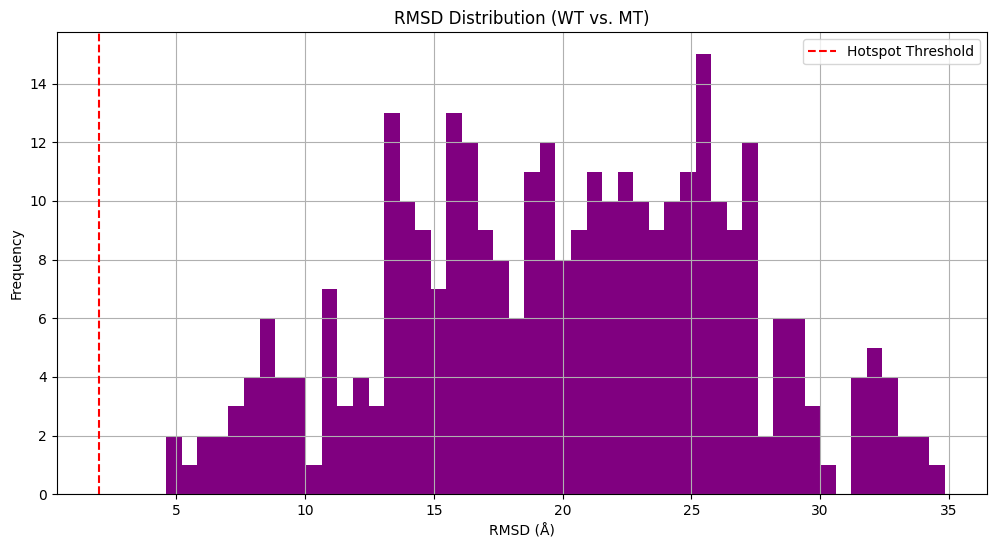

In [34]:
# Visualize RMSD Distribution
plt.figure(figsize=(12, 6))
plt.hist(df_wt['rmsd_per_residue'], bins=50, color='purple')
plt.axvline(rmsd_threshold, color='red', linestyle='--', label='Hotspot Threshold')
plt.title("RMSD Distribution (WT vs. MT)")
plt.xlabel("RMSD (Å)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Save Mutation Analysis to CSV
mutation_report.to_csv('detailed_mutation_report.csv', index=False)
print("\nDetailed mutation analysis saved to 'detailed_mutation_report.csv'")



Detailed mutation analysis saved to 'detailed_mutation_report.csv'


In [36]:
mutations['mutant_residue'] = df_mt.loc[mutations.index, 'residue_name']
print(mutations[['residue_name', 'mutant_residue', 'residue_number', 'chain_id']])


    residue_name mutant_residue  residue_number chain_id
0            THR            VAL               1        A
1            THR            VAL               1        A
2            THR            VAL               1        A
3            THR            VAL               1        A
4            THR            VAL               1        A
..           ...            ...             ...      ...
322          ASN            GLU              46        A
323          ASN            GLU              46        A
324          ASN            GLU              46        A
325          ASN            GLU              46        A
326          ASN            GLU              46        A

[314 rows x 4 columns]


<ipython-input-36-8ab64ffeb13a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutations['mutant_residue'] = df_mt.loc[mutations.index, 'residue_name']
